In [168]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plot
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 14})

In [124]:
# Two layer Neural Net
class NeuralNet:
    def __init__(self, size_in, size_out, n, rate = 0.1, w_decay = 0, av = None, av_ = None, loss = None, loss_ = None):
        self.input = np.zeros((size_in, 1), dtype=np.float64)
        self.output = np.zeros((size_out, 1), dtype=np.float64)
        self.weight = [None, None, None]
        self.bias = [None, None, None]
        self.layer = [None, None]
        self.z = [None, None, None]
        self.weight_ = [None, None, None]
        self.bias_ = [None, None, None]
        self.weight[0] = np.random.rand(n, size_in) * np.sqrt(2 / size_in)
        self.weight[1] = np.random.rand(n, n) * np.sqrt(2 / n)
        self.weight[2] = np.random.rand(size_out, n) * np.sqrt( 2 / n)
        self.bias[0] = np.random.rand(n, 1)
        self.bias[1] = np.random.rand(n, 1)
        self.bias[2] = np.random.rand(size_out, 1)
        self.layer[0] = np.zeros((n, 1), dtype=np.float64)
        self.layer[1] = np.zeros((n, 1), dtype=np.float64)
        self.z[0] = np.zeros((n, 1), dtype=np.float64)
        self.z[1] = np.zeros((n, 1), dtype=np.float64)
        self.z[2] = np.zeros((size_out, 1), dtype=np.float64)
        self.weight_[0] = np.zeros((n, size_in), dtype=np.float64)
        self.weight_[1] = np.zeros((n, n), dtype=np.float64)
        self.weight_[2] = np.zeros((size_out, n), dtype=np.float64)
        self.bias_[0] = np.zeros((n, 1), dtype=np.float64)
        self.bias_[1] = np.zeros((n, 1), dtype=np.float64)
        self.bias_[2] = np.zeros((size_out, 1), dtype=np.float64)
        self.rate = rate
        self.w_decay = w_decay
        
        if(hasattr(av, '__call__')):
            self.activate = av
        if(hasattr(av_, '__call__')):
            self.activate_ = av_
        if(hasattr(loss, '__call__')):
            self.cost = loss
        if(hasattr(loss_, '__call__')):
            self.cost_ = loss_
    
    def activate(self, x):
        return (1 - np.exp(-(x * 2))) / (1 + np.exp(-(x * 2)))
    
    def activate_(self, x):
        return 1 - np.square(self.activate(x))   
    
    def cost(self, y):
        return (self.output - y) ** 2
    
    def cost_(self, y):
        return (self.output - y) * 2
    
    def feed(self, x):
        self.input = x.T
        self.z[0] = self.weight[0].dot(self.input) + self.bias[0]
        self.layer[0] = self.activate(self.z[0])
        self.z[1] = self.weight[1].dot(self.layer[0]) + self.bias[1]
        self.layer[1] = self.activate(self.z[1])
        self.z[2] = self.weight[2].dot(self.layer[1]) + self.bias[2]
        self.output = self.activate(self.z[2])
        
    def propagate(self, y):
        i_ = self.activate_(self.z[2]) * self.cost_(y)
        self.weight_[2] = i_.dot(self.layer[1].T)
        self.bias_[2] = i_
        c_ = self.weight[2].T.dot(i_)
        
        i_ = self.activate_(self.z[1]) * c_
        self.weight_[1] = i_.dot(self.layer[0].T)
        self.bias_[1] = i_
        c_ = self.weight[1].T.dot(i_)
        
        i_ = self.activate_(self.z[0]) * c_
        self.weight_[0] = i_.dot(self.input.T)
        self.bias_[0] = i_
        
        for i in range(0, 3, 1):
            self.weight[i] -= self.rate * self.weight_[i]
            self.weight[i] *= 1 - self.rate * self.w_decay 
            self.bias[i] -= self.rate * self.bias_[i]
        
    def result(self):
        return self.output

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return (2 / (1 + np.exp(-2 * x))) - 1

def tanh_(x):
    return 1 - np.square(tanh(x))

def relu(x, a = 0.01):
    return x * (x > 0)

def relu_(x, a = 0.01):
    return 1 * (x > 0)
    
def soe(dif):
    return np.square(dif)

def soe_(dif):
    return 2 * dif

In [3]:
#https://medium.com/data-science-group-iitr/logistic-regression-simplified-9b4efe801389
#https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python

In [144]:
net = NeuralNet(2, 1, 6, rate = 1)
x0 = np.array([[0], [0]])
x1 = np.array([[0], [1]])
x2 = np.array([[1], [0]])
x3 = np.array([[1], [1]])
y0 = np.array([[0]])
y1 = np.array([[1]])
y2 = np.array([[1]])
y3 = np.array([[0]])

In [140]:
sum = 0
for i in range(0, 4):
    print(i)
    net.feed(train[i].T)
    print(net.result())
    print(net.cost(res[i]))
    sum += net.cost(res[i])
1 - sum / 4

0
[[ 0.99999999]]
[[ 0.99999998]]
1
[[ 0.99999999]]
[[  1.88067768e-16]]
2
[[ 0.99999999]]
[[  7.41546503e-17]]
3
[[ 0.99999999]]
[[ 0.99999997]]


array([[ 0.50000001]])

In [10]:
c_ = np.zeros(10001)
a_ = np.zeros(10001)

In [146]:
i = 0
train = (x0, x1, x2, x3)
res = (y0, y1, y2, y3)
while i < 10000:
    idx = random.randint(0,3)
    net.feed(train[idx].T)
    c_[i + 1] = net.cost(res[idx])
    net.propagate(res[idx])
    sum = 0
    for j in range(0, 4):
        net.feed(train[j].T)
        sum += net.cost(res[j])
    a_[i + 1] = 1 - sum / 4
    i += 1

In [12]:
x = np.arange(-10, 11, 0.01, dtype=np.float64)

sg = sigmoid(x)
sg_ = sigmoid_(x)

th = tanh(x)
th_ = tanh_(x)

r = relu(x, 0.1)
r_ = relu_(x, 0.1)

square = soe(x)
square_ = soe_(x)

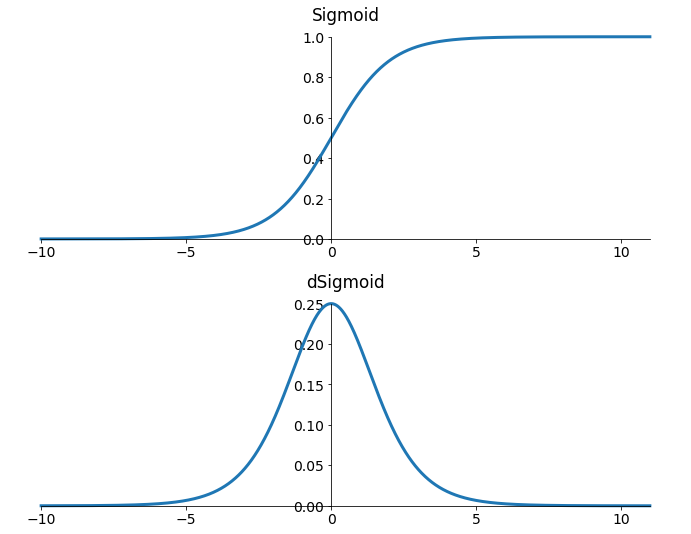

In [24]:
fig, (ax0, ax1) = plot.subplots(nrows=2, figsize=(12,9))

ax0.plot(x, sg, linewidth=3)
ax0.spines['bottom'].set_position('zero')
ax0.set_title('Sigmoid')

ax1.plot(x, sg_, linewidth=3)
ax1.spines['bottom'].set_position('zero')
ax1.set_title('dSigmoid')

for ax in (ax0, ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.spines['left'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.get_yaxis().tick_left()


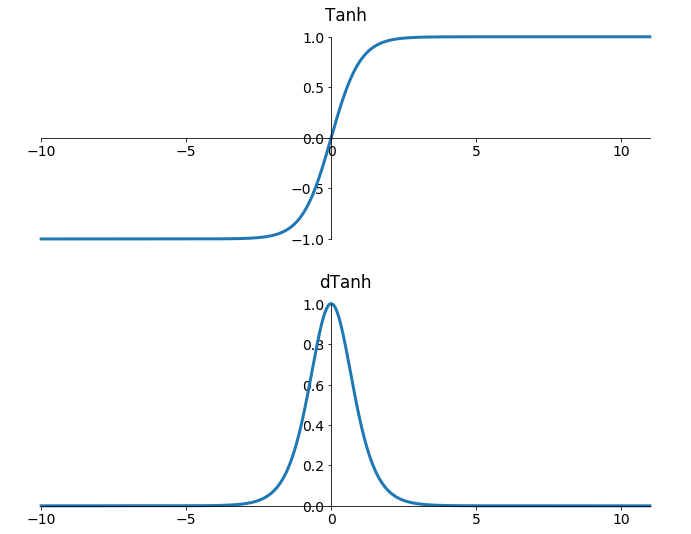

In [25]:
fig, (ax0, ax1) = plot.subplots(nrows=2, figsize=(12,9))

ax0.plot(x, th, linewidth=3)
ax0.spines['bottom'].set_position('center')
ax0.set_title('Tanh')

ax1.plot(x, th_, linewidth=3)
ax1.spines['bottom'].set_position('zero')
ax1.set_title('dTanh')

for ax in (ax0, ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.spines['left'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.get_yaxis().tick_left()

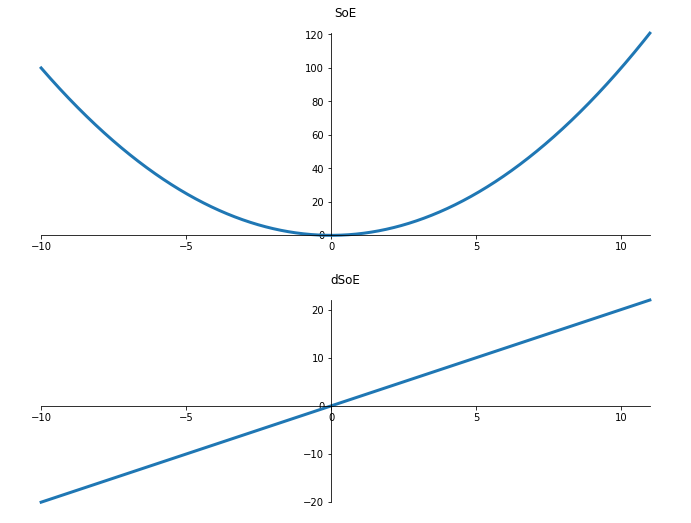

In [15]:
fig, (ax0, ax1) = plot.subplots(nrows=2, figsize=(12,9))

ax0.plot(x, square, linewidth=3)
ax0.spines['bottom'].set_position('zero')
ax0.set_title('SoE')

ax1.plot(x, square_, linewidth=3)
ax1.spines['bottom'].set_position('zero')
ax1.set_title('dSoE')

for ax in (ax0, ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.spines['left'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.get_yaxis().tick_left()

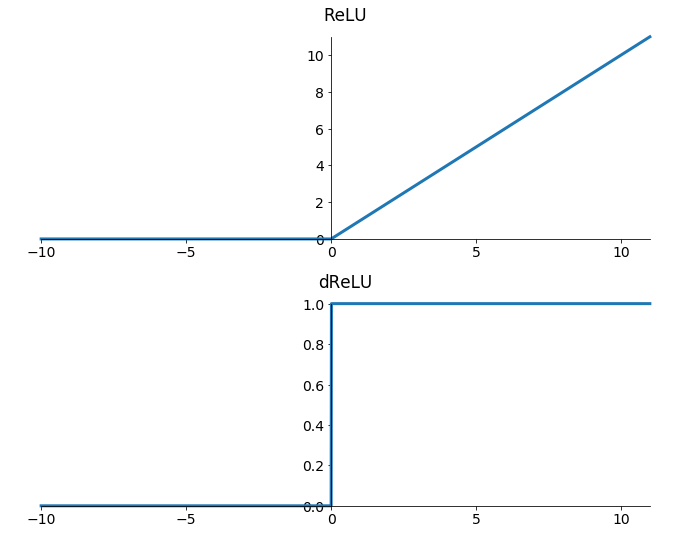

In [27]:
fig, (ax0, ax1) = plot.subplots(nrows=2, figsize=(12,9))

ax0.plot(x, r, linewidth=3)
ax0.spines['bottom'].set_position('zero')
ax0.set_title('ReLU')

ax1.plot(x, r_, linewidth=3)
ax1.spines['bottom'].set_position('zero')
ax1.set_title('dReLU')

for ax in (ax0, ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.spines['left'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.get_yaxis().tick_left()

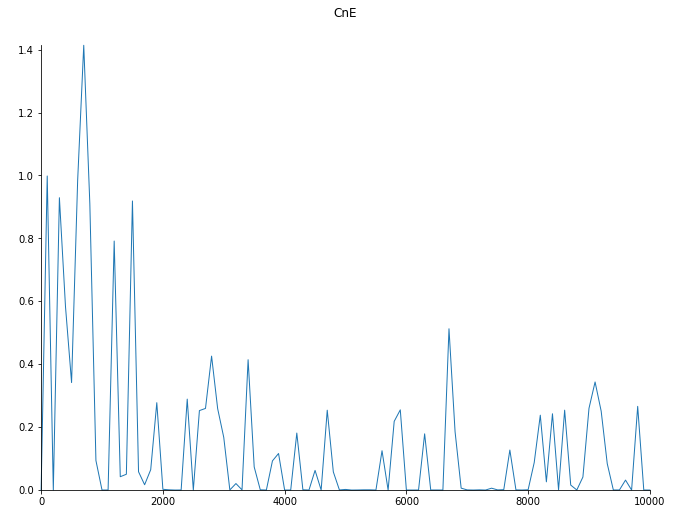

In [21]:
fig, ax0 = plot.subplots(nrows=1, figsize=(12, 9))
x_c = np.arange(0,10001, 100)
c_100 = c_[::100]
ax0.plot(x_c, c_100, linewidth=1)
ax0.spines['bottom'].set_position('zero')
ax0.set_title('CnE')

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.get_xaxis().tick_bottom()
ax0.spines['left'].set_smart_bounds(True)
ax0.spines['left'].set_position('zero')
ax0.spines['bottom'].set_smart_bounds(True)
ax0.get_yaxis().tick_left()

In [3]:
import pickle
import gzip

In [4]:
with gzip.open('tmp/mnist.pkl.gz', 'rb') as file:
    train_set, valid_set, test_set = pickle.load(file, encoding='iso-8859-1')
train_x, train_y = train_set
valid_x, valid_y = valid_set
test_x, test_y = test_set

In [5]:
out = np.zeros((10, 1))
n = 1 # Only one training? If not change it
plot_size = (train_x.shape[0] * n) + 1
xaxis = np.arange(0, plot_size, 1)

In [182]:
ann_sigmoid = NeuralNet(784, 10, 25, rate=0.1, av = sigmoid, av_ = sigmoid_)
cost_sinh, w_sinh, b_sinh = train(ann_sigmoid, train_x, train_y)
validate(ann_sigmoid, valid_x, valid_y)
validate(ann_sigmoid, test_x, test_y)

0.83079116896629146

In [183]:
ann_tanh = NeuralNet(784, 10, 25, rate=0.1)
cost_tanh, w_tanh, b_tanh = train(ann_tanh, train_x, train_y)
validate(ann_tanh, valid_x, valid_y)
validate(ann_tanh, test_x, test_y)

0.51518733193476574

In [166]:
ann_relu = NeuralNet(784, 10, 25, rate=0.0001, av = relu, av_ = relu_)
cost_relu, w_relu, b_relu = train(ann_relu, train_x, train_y)
validate(ann_relu, valid_x, valid_y)

0.26497888365591671

In [165]:
def train(ann, x, y, n = 1):
    i = 0
    epoch = 1
    out = np.zeros((10, 1))
    plot_size = (x.shape[0] * n) + 1
    costs = np.zeros(plot_size)
    w_ = np.zeros(plot_size)
    b_ = np.zeros(plot_size)
    while i < n:
        idx = x.shape[0] - 1
        while idx > -1:
            ann.feed(x[idx].reshape((1, 784)))
            out[y[idx]][0] = 1
            costs[epoch] = ann.cost(out).sum()
            ann.propagate(out)
            w_[epoch] = ann.weight_[2][0][0]
            b_[epoch] = ann.bias_[2][0][0]
            out[y[idx]][0] = 0
            idx -= 1
            epoch += 1
        i += 1
    return (w_, b_, costs)

In [160]:
def validate(ann, x, y):
    idx = x.shape[0] - 1
    sum = 0.0
    out = np.zeros((10, 1))
    while idx > -1:
        ann.feed(x[idx].reshape((1, 784)))
        out[y[idx]][0] = 1
        sum += ann.cost(out).sum()
        out[y[idx]][0] = 0
        idx -=  1
    sum /= x.shape[0]
    return 1 - sum

In [31]:
idx = test_x.shape[0] - 1
sum = 0.0
while idx > -1:
    ann.feed(test_x[idx].reshape((1, 784)))
    y[test_y[idx]][0] = 1
    sum = sum + ann.cost(y).sum()
    y[test_y[idx]][0] = 0
    idx = idx - 1
sum = sum / test_x.shape[0]
print(1 - sum)

0.834135212192


In [148]:
ann_relu.feed(test_x[0].reshape((1, 784)))


array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.]])

In [69]:
plot_x = np.arange(0, 5001)
plot_y = np.zeros(5001)

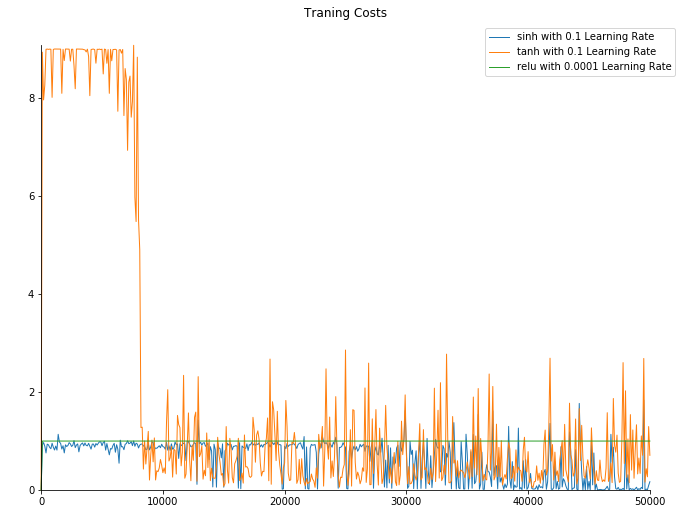

In [149]:
fig, ax0 = plot.subplots(nrows=1, figsize=(12, 9))
ax0.plot(xaxis[::100], cost_sinh[::100], linewidth=1, label='sinh with 0.1 Learning Rate')
ax0.plot(xaxis[::100], cost_tanh[::100], linewidth=1, label='tanh with 0.1 Learning Rate')
ax0.plot(xaxis[::100], cost_relu[::100], linewidth=1, label='relu with 0.0001 Learning Rate')
ax0.spines['bottom'].set_position('zero')
ax0.set_title('Traning Costs')
ax0.legend()

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.get_xaxis().tick_bottom()
ax0.spines['left'].set_smart_bounds(True)
ax0.spines['left'].set_position('zero')
ax0.spines['bottom'].set_smart_bounds(True)
ax0.get_yaxis().tick_left()

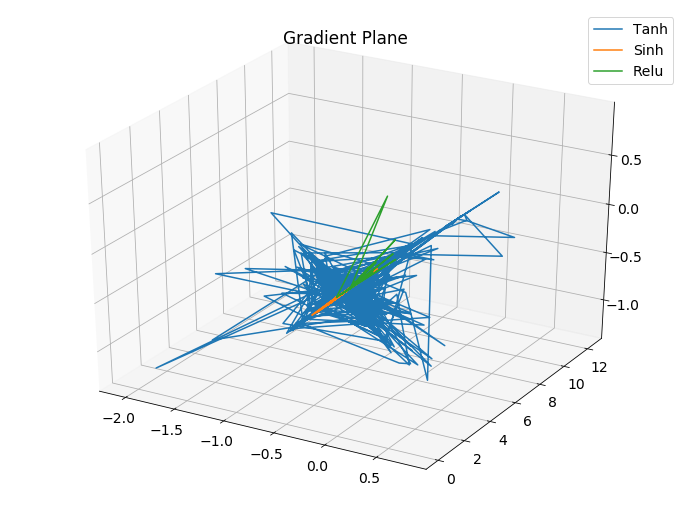

In [190]:
fig = plot.figure(figsize=(12, 9))
ax = fig.gca(projection = '3d')
ax.set_title('Gradient Plane')
ax.plot(w_tanh[::100], b_tanh[::100], cost_tanh[::100], label = 'Tanh')
ax.plot(w_sinh[::100], b_sinh[::100], cost_sinh[::100], label = 'Sinh')
ax.plot(w_relu[::100], b_relu[::100], cost_relu[::100], label = 'Relu')
ax.legend()

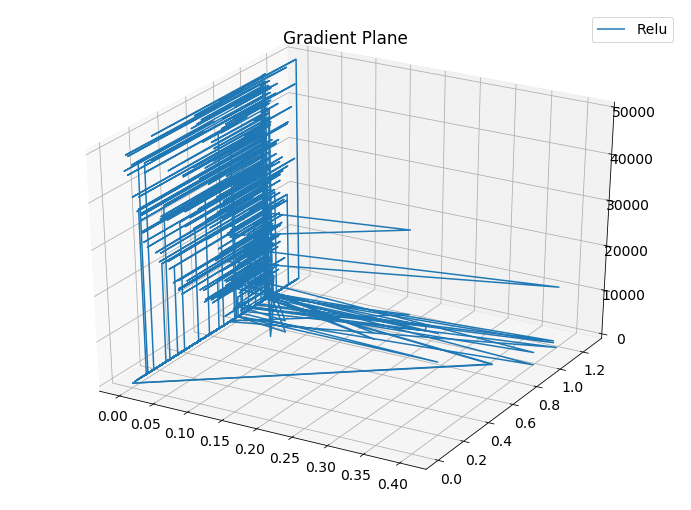

In [191]:
fig = plot.figure(figsize=(12, 9))
ax = fig.gca(projection = '3d')
ax.set_title('Gradient Plane')
#ax.plot(w_tanh[::100], b_tanh[::100], np.vstack((cost_relu[::100], xaxis[::100])), label = 'Tanh')
#ax.plot(w_sinh[::100], b_sinh[::100], np.vstack((cost_relu[::100], xaxis[::100])), label = 'Sinh')
ax.plot_wireframe(w_relu[::100], b_relu[::100], np.vstack((cost_relu[::100], xaxis[::100])), label = 'Relu')
ax.legend()